# Libraries

In [1]:
import pandas as pd
import json
import os.path
import pprint
import numpy as np
import openpyxl

from datetime import datetime

from yaml import load, FullLoader

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

import re
from urllib.parse import urlparse

# Read data

In [2]:
df_sabi = pd.read_csv("sabi2/sabi_checked_clean.csv")
df_sabi.head()

,Unnamed: 0,Company Name,NIF Code,City,Country,Address,Postal Code,Province,Region,Web site,Web site checked,Telephone,unnamed.1,Original Company Name,Original City,Original Address
0,0,Confecciones borsao coop,F50121029,Borja,SPAIN,Calle Abadia,50540,Zaragoza,Aragón,NaN,NaN,+34 97/6866088,NaN,Confecciones Borsao Coop Ltda (EN Liquidacion),BORJA,CALLE ABADIA
1,1,Fitosanitarios novarcan,B38494852,San Cristobal De La Laguna,SPAIN,"Carretera General Del Norte, 116",38206,Santa Cruz de Tenerife,Canarias,www.novarcan.com,NaN,NaN,NaN,Fitosanitarios Novarcan SL,SAN CRISTOBAL DE LA LAGUNA,"CARRETERA GENERAL DEL NORTE, 116"
2,2,111 conventuring,B38756938,La Matanza De Acentejo,SPAIN,"Calle Acentejo, 74",38370,Santa Cruz de Tenerife,Canarias,NaN,NaN,NaN,NaN,111 Conventuring SL,LA MATANZA DE ACENTEJO,"CALLE ACENTEJO, 74"
3,3,Centro autorizado de recogida y desguace de ve...,B06333470,Villafranca De Los Barros,SPAIN,"Calle Cruz, 20",6220,Badajoz,Extremadura,www.dtb3.es,https://www.dtb3.es,+34 92/4520273,NaN,Centro Autorizado de Recogida Y Desguace de Ve...,VILLAFRANCA DE LOS BARROS,"CALLE CRUZ, 20"
4,4,Grupo home pro hogar,B05338306,Barcelona,SPAIN,"Calle Llull, 399 - P. 4 Pta. 4",8019,Barcelona,Cataluña,NaN,https://planreforma.com,NaN,NaN,Grupo Home PRO Hogar S.L.,BARCELONA,"CALLE LLULL, 399 - P. 4 PTA. 4"


# Searcher

## Load credentials

In [3]:
with open("my_data/config.yml", 'r') as f:
    config = load(f, Loader=FullLoader)

## Launch query as with first row name

In [8]:
service = build("customsearch", "v1", developerKey=config['key'])

# res = (service.cse().list(q="Acciona construcción AND inurl:contact OR inurl:nosotros", cx=config['search_engine_id'], gl=config["geolocation"], lr="lang_"+config["language"]).execute())

query = "big bang theory"
res = (service.cse().list(q=query, cx=config['search_engine_id'], gl=config["geolocation"], lr="lang_"+config["language"]).execute())

for item in res["items"]:
    print(item.get("title"))

The Big Bang Theory (@bigbangtheory) • Instagram photos and ...
Controversial: Lucy was the worst thing to happen to this show. I ...
The Big Bang Theory: The Complete Series (Limited ... - Amazon.com
The Big Bang Theory - Season 12 - Prime Video
Amazon.com: ​Little People Collector The Big Bang Theory - Juego ...
Warner Bros. Studio Tour Hollywood ¡BAZINGA! Explore los sets ...
The Big Bang Theory - Minix Colectible Figurines
El día que Elon Musk lavó platos en The Big Bang Theory: la escena ...
Warner Bros. Studio Tour Hollywood The Big Bang Theory Sets ...
Ver The Big Bang Theory | Max


In [85]:
pprint.pprint(res)

{'context': {'title': 'urlfinding1'},
 'items': [{'displayLink': 'www.loteriasyapuestas.es',
            'formattedUrl': 'https://www.loteriasyapuestas.es/es',
            'htmlFormattedUrl': 'https://www.<b>loteriasyapuestas</b>.es/es',
            'htmlSnippet': 'Compra tu <b>apuesta</b> en nuestros juegos de '
                           '<b>Lotería</b> Nacional, Euromillones, Primitiva, '
                           'Bonoloto, El Gordo, La Quiniela, <b>Lotería</b> de '
                           'Navidad y El Niño.',
            'htmlTitle': '<b>Loterías</b> y <b>Apuestas</b> del <b>Estado</b> '
                         '- Venta oficial online',
            'kind': 'customsearch#result',
            'link': 'https://www.loteriasyapuestas.es/es',
            'pagemap': {'cse_image': [{'src': 'https://www.loteriasyapuestas.es//f/loterias/estaticos/imagenes/imagen_facebook_loterias.png'}],
                        'cse_thumbnail': [{'height': '200',
                                      

# Launch query in dataset

In [7]:


def build_term_query(row, colName):
    """
    Function that helps to build the term query

    Args:
        row (pd dataframe row): a row from the set of enterprises we are interested in.
        colName (str): the name of the column we want to extract the data

    Output:
        str: empty string, if it has no value, or the cell value, if it has a value
    """
    
    if row[colName] is np.nan or not row[colName]:
        return ""
    return str(row[colName]) + " "


def load_blocklist(filepath = "my_data/blocklist.txt"):
    """
    Function to load the blocklist file where the domains and extensions to be excluded are stored.
    Args:
        - filepath (str): path to where the domains and extensions to be excluded are stored in a .txt file
    """
    with open(filepath, "r") as file:
        blocklist = [line.strip() for line in file if line.strip() and not line.startswith("#")]
    return blocklist


def build_query_with_filters(row, code = 1, blocklist = None):
    """
    Function that build the query using the blocklist elements to be filtered out.

    Args:
        - row and code to passed to build_query()
        - blocklist (list): list of elements to be filtered out.

    Output:
        empty string, if it has no value, or the cell value, if it has a value
    """

    query_code, base_query = build_query(row, code)

    if not blocklist:
        blocklist = load_blocklist()

    filters = " ".join([f"-site:{item}" for item in blocklist])
    term_query = f"{base_query}{filters}" 
        
    return query_code + '-site', term_query



def build_query(row, code = 1):
    """
    Function that build the term query to be launched to the API custom searcher

    Args:
        row (pd dataframe row): a row from the set of enterprises we are interested in.
        code (int): the code of the term query to be built. Possible cases:
            - 1: Company Name
            - 2: Company Name + City + Address
            - 3: Company Name + Postal Code
            - 4: Company Name + NIF
            - 5: Company Name + websie
            - 6: Company Name + inurl:Company Name
            - 7: Company Name + inanchor:Company Name
            - 8: Company Name + inanchor:contact...
            - 9: Company Name + intext:contact...
            - 10: Company Name + inurl:contact...

    Output:
        empty string, if it has no value, or the cell value, if it has a value
    
    """
    term_query = ""
    # print(code)

    match code:
        case 1:
            query_code = "Company Name"
            term_query += build_term_query(row, "Company Name")

        case 2:
            query_code = 'Company Name + City + Address'
            term_query += build_term_query(row, "Company Name")
            term_query += build_term_query(row, "City")
            term_query += build_term_query(row, "Address")
            
        case 3:
            query_code = "Company Name + Postal Code" # region (province) + city
            term_query += build_term_query(row, "Company Name")
            term_query += build_term_query(row, "Postal Code")

        case 4:
            query_code = "Company Name + NIF"
            term_query += build_term_query(row, "Company Name")
            term_query += build_term_query(row, "NIF Code")
            
        case 5:
            query_code = "Company Name + website"
            term_query = f'{build_term_query(row, "Company Name")} website '

        case 6:
            query_code = "Company Name + intitle:Company Name"
            base_name = build_term_query(row, "Company Name")
            term_query = f'{base_name} intitle:"{base_name.strip()}" '

        case 7:
            query_code = "Company Name + inurl:Company Name"
            base_name = build_term_query(row, "Company Name")
            term_query = f'{base_name} inurl:"{base_name.strip()}" '

        case 8:
            query_code = 'Company Name + inanchor:contact'
            term_query = f'{build_term_query(row, "Company Name")} AND (inanchor:"contact" OR inanchor:"nosotros" OR inanchor:"atención al cliente" OR inanchor:"servicios" OR inanchor:"legal" OR inanchor:"about us") '

        case 9:
            query_code = 'Company Name + intext:contact'
            term_query = f'{build_term_query(row, "Company Name")} AND (intext:"contact" OR intext:"nosotros" OR intext:"atención al cliente" OR intext:"servicios" OR intext:"legal" OR intext:"about us") '

        case 10:
            query_code = 'Company Name + inurl:contact'
            term_query = f'{build_term_query(row, "Company Name")} AND (inurl:"contact" OR inurl:"nosotros" OR inurl:"atención al cliente" OR inurl:"servicios" OR inurl:"legal" OR inurl:"about us") '

        case _:
            raise ValueError("Introduce un código válido")

    return query_code, term_query
    return query_code, term_query


def store_results(company_name, results):
    """
    Function to store the results in a pandas dataframe

    Args:
        - company_name (str): the company name whose Url we aim to find
        - results (json): object obtained after launching the query that contains the search results

    Output:
        - df_results (pd.df): results obtained in a structured format
        - df_resultsInfo (pd.df): information abouot the results (time spent, total number of results)
    """
    
    df_results = pd.DataFrame([
        {
            "order": i,
            "query": query_code,  
            "company_name": company_name,
            "title": item.get("title"),
            "snippet": item.get("snippet"),
            "link": item.get("link"),
            "display_link": item.get("displayLink"),
        }
        for i, item in enumerate(results.get("items", []))
    ])

        
    df_resultsInfo = pd.DataFrame([
        {
            "company_name": company_name,
            "search_time": results["searchInformation"]["searchTime"],
            "total_results": results["searchInformation"]["totalResults"],
        }
    ])

    return df_results, df_resultsInfo


def export_results(df_results, df_resultsInfo, config):
    """
    Function to export the dataframe results; It stores the results in an Excel

    Args:
        - df_results (pd.df): results obtained from the Store_results after launching the search
        - df_resultsInfo (pd.df): results obtained from the Store_results function that contains information from the search 
        - config (yaml): file that contains the api key and the search configuration
    
    """

    df_searchInfo = pd.DataFrame([
    {
        "search_engine": config["search_engine"],
        "search_engine_id": config['search_engine_id'],
        "geolocation": config["geolocation"],
        "language": config["language"]
    }
    ])
    
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"search_results_{timestamp}.xlsx"
    
    with pd.ExcelWriter(filename) as writer:
        df_results.to_excel(writer, sheet_name="Search Results", index=False)
        df_resultsInfo.to_excel(writer, sheet_name="Results Info", index=False)
        df_searchInfo.to_excel(writer, sheet_name = "Search Info", index= False)
    
    print(f"File saved as {filename}")
    



In [8]:
df_sabi

,Unnamed: 0,Company Name,NIF Code,City,Country,Address,Postal Code,Province,Region,Web site,Web site checked,Telephone,unnamed.1,Original Company Name,Original City,Original Address
0,0,Confecciones borsao coop,F50121029,Borja,SPAIN,Calle Abadia,50540,Zaragoza,Aragón,NaN,NaN,+34 97/6866088,NaN,Confecciones Borsao Coop Ltda (EN Liquidacion),BORJA,CALLE ABADIA
1,1,Fitosanitarios novarcan,B38494852,San Cristobal De La Laguna,SPAIN,"Carretera General Del Norte, 116",38206,Santa Cruz de Tenerife,Canarias,www.novarcan.com,NaN,NaN,NaN,Fitosanitarios Novarcan SL,SAN CRISTOBAL DE LA LAGUNA,"CARRETERA GENERAL DEL NORTE, 116"
2,2,111 conventuring,B38756938,La Matanza De Acentejo,SPAIN,"Calle Acentejo, 74",38370,Santa Cruz de Tenerife,Canarias,NaN,NaN,NaN,NaN,111 Conventuring SL,LA MATANZA DE ACENTEJO,"CALLE ACENTEJO, 74"
3,3,Centro autorizado de recogida y desguace de ve...,B06333470,Villafranca De Los Barros,SPAIN,"Calle Cruz, 20",6220,Badajoz,Extremadura,www.dtb3.es,https://www.dtb3.es,+34 92/4520273,NaN,Centro Autorizado de Recogida Y Desguace de Ve...,VILLAFRANCA DE LOS BARROS,"CALLE CRUZ, 20"
4,4,Grupo home pro hogar,B05338306,Barcelona,SPAIN,"Calle Llull, 399 - P. 4 Pta. 4",8019,Barcelona,Cataluña,NaN,https://planreforma.com,NaN,NaN,Grupo Home PRO Hogar S.L.,BARCELONA,"CALLE LLULL, 399 - P. 4 PTA. 4"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,Burgalesa de fitnes,B09422692,Burgos,SPAIN,"Plaza Francisco Sarmiento, S/N - Bj",9005,Burgos,Castilla y León,NaN,NaN,NaN,ha cerrado,Burgalesa de Fitnes SL,BURGOS,"PLAZA FRANCISCO SARMIENTO, S/N - BJ"
96,96,Talleres hernandez martin,B48137202,Bilbao,SPAIN,"Calle Iruña, 1",48014,Vizcaya,País Vasco,NaN,https://www.tallereshernandezmartin.com,+34 94/4753878,NaN,Talleres Hernandez Martin SL,BILBAO,"CALLE IRUÑA, 1"
97,97,Construccions i reformes carcom ribes,B67249672,Vilanova I La Geltru,SPAIN,"Calle Riu Ebre, 4",8800,Barcelona,Cataluña,NaN,https://construccionsireformescarmona.com,NaN,NaN,Construccions I Reformes Carcom. Ribes S.L.,VILANOVA I LA GELTRU,"CALLE RIU EBRE, 4"
98,98,Vega centro 1907,B06663504,Almendralejo,SPAIN,"Calle Martires, 9",6200,Badajoz,Extremadura,www.elzamorano.es,www.elzamorano.es,+34 92/4660204,NaN,Vega Centro 1907 SL,ALMENDRALEJO,"CALLE MARTIRES, 9"


In [9]:
for i, row in df_sabi.iterrows():
    
    # query_code, query_term = build_query(row, 2)
    query_code, query_term = build_query_with_filters(row, 1)
    print(query_term)
    print()

    

Confecciones borsao coop -site:twitter.com -site:x.com -site:facebook.com -site:instagram.com -site:wikipedia.org -site:linkedin.com -site:pinterest.com -site:reddit.com -site:tiktok.com -site:tumblr.com -site:blogspot.com -site:medium.com -site:quora.com -site:flickr.com -site:yahoo.com -site:bing.com -site:www.yelp.com -site:paginasamarillas.es -site:www.einforma.com -site:empresite.eleconomista.es -site:cincodias.elpais.com -site:cnmv.es -site:infonif.economia3.com -site:librebor.me -site:www.datoscif.es -site:www.axesor.es -site:boe.es -site:ranking-empresas.eleconomista.es -site:iberinform.es -site:empresas.economigadigital.es -site:www.expansion.com -site:www.informa.es -site:www.dnb.com -site:www.info-clipper.com -site:www.empresia.es -site:www.proveedores.com -site:empresas.dela.eus -site:www.citiservi.es -site:www.infoempresa.com -site:dk.kompass.com -site:www.lokinn.com -site:dimequienes.com -site:https://www.ceginformacio.hu -site:www.empresascif.com -site:www.construccion24

# Quality of queries

## queries

In [14]:
import time
dic_results = {}

for code in range(1,11):
    print(f"==== query code: {code} ==== ")

    start_time = time.time()
    
    for i, row in df_sabi.iterrows():
        # to avoid HttpError 429
        # time.sleep(20)  
        time.sleep(0.6)
        query_code, query_term = build_query_with_filters(row, code)
        service = build("customsearch", "v1", developerKey=config['key'])
        search_results = (service.cse().list(q=query_term, cx=config['search_engine_id'], gl=config["geolocation"], lr="lang_"+config["language"]).execute())
        # print(query_term)        
        if i == 0:
            results, results_info = store_results(row["Company Name"], search_results)
        else:
            new_results, new_results_info = store_results(row["Company Name"], search_results)
            results = pd.concat([results, new_results], axis = 0)
            results_info = pd.concat([results_info, new_results_info], axis = 0)

    end_time = time.time()
    elapsed_time = end_time - start_time  
    print(f"Execution time of query {code} took {elapsed_time}")

    results = results.reset_index().drop(columns = "index")
    results_info = results_info.reset_index().drop(columns = "index")
    export_results(results, results_info, config)
    dic_results[f"termQuery_{code}"] = results

    



==== query code: 2 ==== 
Execution time of query 2 took 119.41309905052185
File saved as search_results_2025-02-26_22-55-11.xlsx
==== query code: 3 ==== 
Execution time of query 3 took 116.15101504325867
File saved as search_results_2025-02-26_22-57-07.xlsx
==== query code: 4 ==== 
Execution time of query 4 took 106.69577717781067
File saved as search_results_2025-02-26_22-58-54.xlsx
==== query code: 5 ==== 
Execution time of query 5 took 120.96583342552185
File saved as search_results_2025-02-26_23-00-55.xlsx
==== query code: 6 ==== 
Execution time of query 6 took 108.58923816680908
File saved as search_results_2025-02-26_23-02-44.xlsx
==== query code: 7 ==== 
Execution time of query 7 took 107.87842440605164
File saved as search_results_2025-02-26_23-04-32.xlsx
==== query code: 8 ==== 
Execution time of query 8 took 121.29409098625183
File saved as search_results_2025-02-26_23-06-33.xlsx
==== query code: 9 ==== 
Execution time of query 9 took 123.25960779190063
File saved as search_r

In [15]:
dic_results

{'termQuery_1':      order              query              company_name  \
 0        0  Company Name-site  Confecciones borsao coop   
 1        1  Company Name-site  Confecciones borsao coop   
 2        2  Company Name-site  Confecciones borsao coop   
 3        3  Company Name-site  Confecciones borsao coop   
 4        4  Company Name-site  Confecciones borsao coop   
 ..     ...                ...                       ...   
 913      5  Company Name-site                Alia green   
 914      6  Company Name-site                Alia green   
 915      7  Company Name-site                Alia green   
 916      8  Company Name-site                Alia green   
 917      9  Company Name-site                Alia green   
 
                                                  title  \
 0                                             Untitled   
 1    Bodegas Borsao gana el premio “Mejor vino tint...   
 2                   Listado grandes beneficiarios 2021   
 3                         

## web comparation

In [16]:
def extract_tld(url):
    """
    Extracts the TLD (Top-Level Domain) from an URL.

    Parameters:
        url (str): the URL of interest

    Returns:
        str: the TLD (eg. ".com", ".org", ".es"), o None if not found.
    """
    if not url or not isinstance(url, str) or url.strip() == "":
        return None 
    
    try:
        parsed_url = urlparse(url.strip())
        domain = parsed_url.netloc.lower() if parsed_url.netloc else parsed_url.path.lower()

        
        parts = re.findall(r'\.(\w+)', domain)
        last = parts[-1] if parts else None
        
        return(last) 


    except Exception:
        return None  



def normalize_url(url):
    """
    Normalize URL by removing www, http/https and TLDs.
    
    Args:
        url (str): URL

    Returns:
        str: URL normalized
    """
    if not isinstance(url, str) or not url.strip():
        return ""

    # parse url
    parsed_url = urlparse(url.strip())
    domain = parsed_url.netloc if parsed_url.netloc else parsed_url.path

    # remove "www."
    domain = re.sub(r'^www\.', '', domain)

    # remove schema (http, https)
    domain = domain.split(':')[0]

    # remove tld
    tld = extract_tld(url)
    domain = re.sub(fr'\.({tld})$', '', domain)

    return domain.lower()

def compare_urls(url1, url2):
    """
    Compares two normalised URLs, i.e, ignoreing differences such as the protocol, www and TLD.

    Args:
        url1 (str): first URL
        url2 (str): second URL

    Returns:
        bool: True if URLs are equivalent, False otherwise
    """
    # print(url1, normalize_url(url1) == normalize_url(url2))
    return normalize_url(url1) == normalize_url(url2)



# example
urls_to_compare = [
    ("https://www.mercadona.es", "http://mercadona.com"),
    ("http://blog.ejemplo.org", "https://ejemplo.org"),
    ("https://www.empresa.net", "empresa.com"),
    ("https://inditex.com", "https://www.inditex.es"),
    ("http://google.com", "https://google.es"),
]

for u1, u2 in urls_to_compare:
    print(f"{u1} vs {u2} → {compare_urls(u1, u2)}")


https://www.mercadona.es vs http://mercadona.com → True
http://blog.ejemplo.org vs https://ejemplo.org → False
https://www.empresa.net vs empresa.com → True
https://inditex.com vs https://www.inditex.es → True
http://google.com vs https://google.es → True


In [34]:
new_dic_results = dic_results

for query, df in new_dic_results.items():
    new_dic_results[query]["matching"] = dic_results[query].apply(lambda row: compare_urls(row["link"], df_sabi[df_sabi["Company Name"] == row["company_name"]]["Web site checked"].values[0]), axis=1)
    new_dic_results[query]["original"] = dic_results[query].apply(lambda row: df_sabi[df_sabi["Company Name"] == row["company_name"]]["Web site checked"].values[0], axis=1)

In [35]:
new_dic_results["termQuery_1"]

,order,query,company_name,title,snippet,link,display_link,matching,original
0,0,Company Name-site,Confecciones borsao coop,Untitled,"... COOP ANDALUZA GANADERA DEL VAL LE DE LOS, ...",https://www.oficinavirtual.pap.hacienda.gob.es...,www.oficinavirtual.pap.hacienda.gob.es,False,NaN
1,1,Company Name-site,Confecciones borsao coop,Bodegas Borsao gana el premio “Mejor vino tint...,"Nov 27, 2024 ... 'Viña Borgia 2023' de Bodegas...",https://redaccion.camarazaragoza.com/bodegas-b...,redaccion.camarazaragoza.com,False,NaN
2,2,Company Name-site,Confecciones borsao coop,Listado grandes beneficiarios 2021,ES F79366878 COOP.AGRO-ALIMENTARIAS ESPAñA U.D...,https://www.oficinavirtual.pap.hacienda.gob.es...,www.oficinavirtual.pap.hacienda.gob.es,False,NaN
3,3,Company Name-site,Confecciones borsao coop,Untitled,"Jan 7, 2025 ... ... BORSAO SA, ENV/2023/000002...",https://www.miteco.gob.es/content/dam/miteco/e...,www.miteco.gob.es,False,NaN
4,4,Company Name-site,Confecciones borsao coop,Untitled,"Jun 26, 2023 ... BODEGAS COOPERATIVAS DE ALICA...",https://www.miteco.gob.es/content/dam/miteco/e...,www.miteco.gob.es,False,NaN
...,...,...,...,...,...,...,...,...,...
913,5,Company Name-site,Alia green,"Green Room [DVD + Digital] : Patrick Stewart, ...",Amazon.com: Green Room [DVD + Digital] : Patri...,https://www.amazon.com/-/es/Green-Room-Digital...,www.amazon.com,False,www.greenalia.es
914,6,Company Name-site,Alia green,Pago de la Tarifa de Inmigrante: Consejos sobr...,"Jul 27, 2018 ... Durante su cita en la Embajad...",https://www.uscis.gov/es/es/tarifa-inmigrante/...,www.uscis.gov,False,www.greenalia.es
915,7,Company Name-site,Alia green,La tecnología de Getac se alía con la Cruz Ver...,La entrega incansable de los voluntarios de Cr...,https://www.getac.com/latam/news/la-tecnologia...,www.getac.com,False,www.greenalia.es
916,8,Company Name-site,Alia green,LOALCO GREEN | ALIA - Clúster Logístico Aragón,Loalco Green es un operador logístico especial...,https://aliaragon.es/alia-connect/loalco-green/,aliaragon.es,False,www.greenalia.es


## Building visualizations

### company results counts

In [20]:
# dictionary to count the number of results per company

dic_count_companies = {}

for i in range(1,11):
    print(i)
    keys = dic_results["termQuery_"+str(i)].groupby("company_name").size().index
    values = dic_results["termQuery_"+str(i)].groupby("company_name").size().values
    
    for k, v in zip(keys, values):
        if k not in dic_count_companies:
            dic_count_companies[k] = v
        else:
            dic_count_companies[k] += v


for k, v in dic_count_companies.items():
    dic_count_companies[k] = int(v)


1
2
3
4
5
6
7
8
9
10


In [21]:
dic_count_companies

{'111 conventuring': 23,
 'Activa ventas desarrollo comercial': 76,
 'Algorspain': 13,
 'Alia green': 72,
 'Almacenes las mimbreras': 47,
 'Alquimia usero': 53,
 'Aluminios de la torre taboada': 64,
 'Anclatec': 37,
 'Aplicaciones comerciales de refrigeracion': 70,
 'Apt neumatica': 70,
 'Aralia servicios sociosanitarios': 92,
 'Arbesa y lau': 40,
 'Betapan': 45,
 'Buen sonido baleares': 70,
 'Burgalesa de fitnes': 61,
 'Caldereria y reparacion naval gallega': 60,
 'Centro autorizado de recogida y desguace de vehiculos tierra de barros': 58,
 'Cermachado': 16,
 'Cervic': 100,
 'Clinica dental agullo vilaro': 47,
 'Compra tu coche online': 77,
 'Confecciones borsao coop': 39,
 'Construcciones juan antoniolv': 31,
 'Construccions i reformes carcom ribes': 33,
 'Coslinda investments': 21,
 'Couso fernandez': 85,
 'Dentsee2016': 17,
 'Dinelec montajes electricos': 36,
 'Disgoco galicia': 8,
 'Ediberto diez diez': 67,
 'Electrodomesticos san vicente': 77,
 'Electrofoton energia': 39,
 'Ense

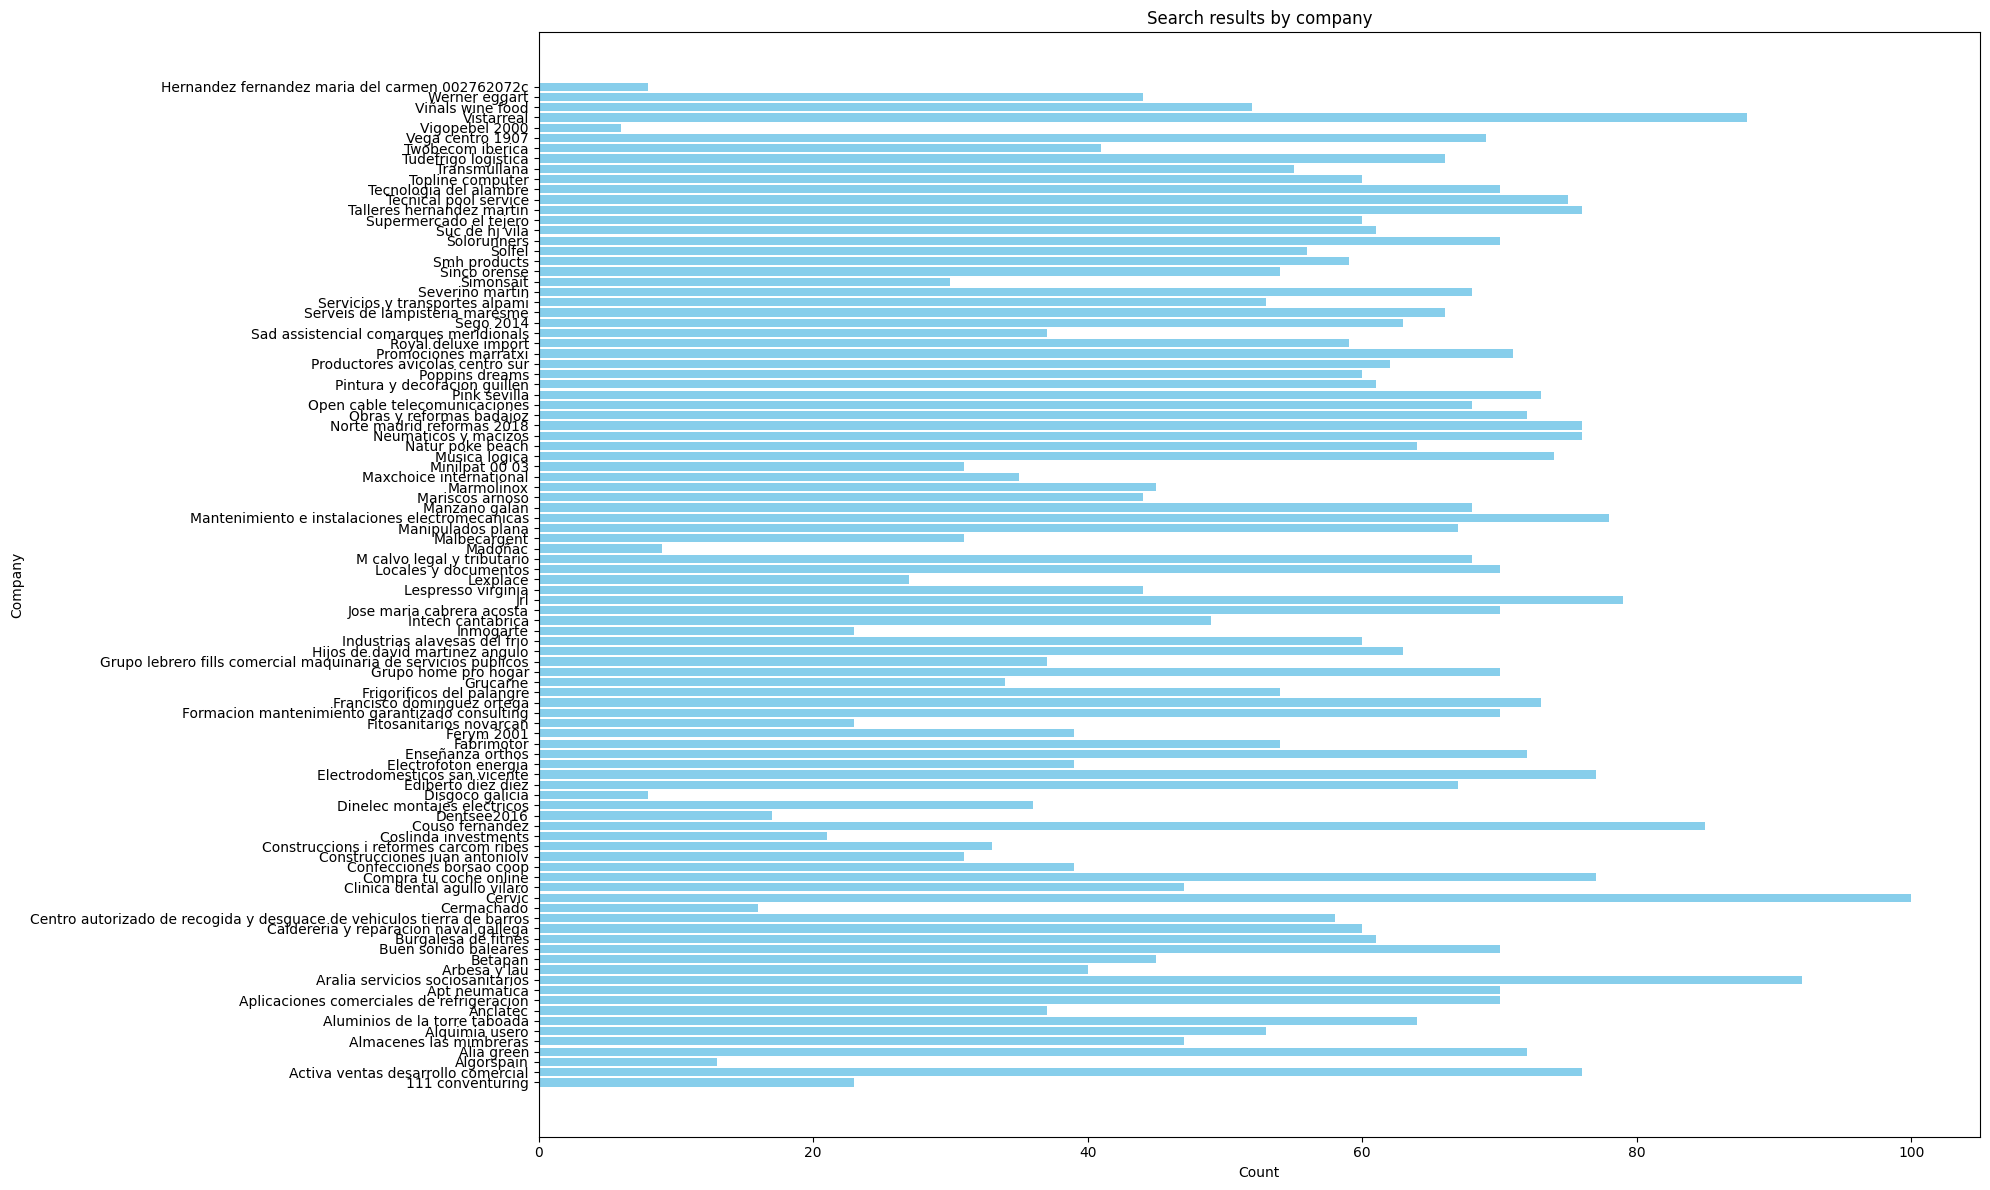

In [22]:
import matplotlib.pyplot as plt
import numpy as np

company_names = list(dic_count_companies.keys())
values = list(dic_count_companies.values())

# barplot
plt.figure(figsize=(20, 12))
plt.barh(company_names, values, color='skyblue') 

plt.xlabel('Count')
plt.ylabel('Company')
plt.title('Search results by company')
plt.yticks(label=1)

plt.tight_layout()
plt.show()

### term query results counts

In [23]:
## dictionary to count the results per query

dic_count_queries = {}

for i in range(1,11):
    dic_count_queries[f"termQuery_{i}"] = dic_results[f"termQuery_{i}"].shape[0]
    

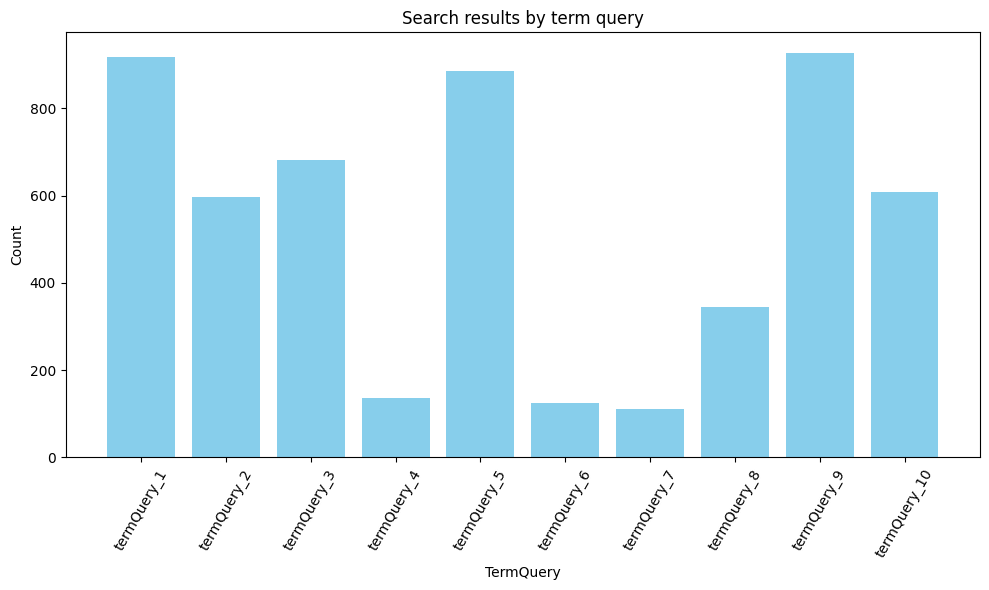

In [24]:
import matplotlib.pyplot as plt
import numpy as np

term_queries = list(dic_count_queries.keys())
values = list(dic_count_queries.values())

# barplot
plt.figure(figsize=(10, 6))
plt.bar(term_queries, values, color='skyblue') 

plt.xlabel('TermQuery')
plt.ylabel('Count')
plt.title('Search results by term query')
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

### ground truth results

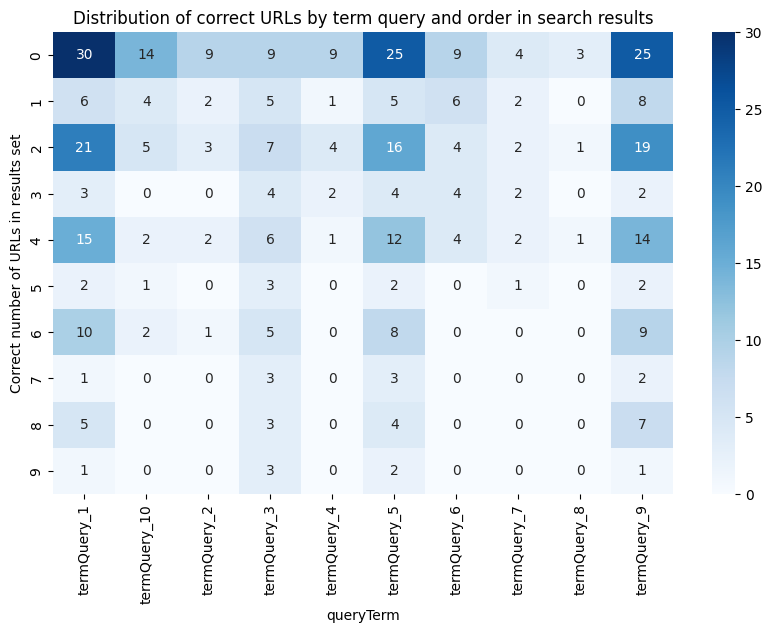

In [25]:
heatmap_data = []

for term_query, df in new_dic_results.items():
    for index, row in df.iterrows():
        heatmap_data.append({
            'queryType': term_query,  
            'position': row['order'],  
            'matching': 1 if row['matching'] else 0 
        })

heatmap_df = pd.DataFrame(heatmap_data)

# dataframe to table
heatmap_pivot = heatmap_df.pivot_table(index='position', columns='queryType', values='matching', aggfunc='sum', fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_pivot, cmap="Blues", annot=True, fmt="d")

plt.xlabel("queryTerm")
plt.ylabel("Correct number of URLs in results set")
plt.title("Distribution of correct URLs by term query and order in search results")

plt.show()


In [148]:
new_dic_results["termQuery_10"]

,order,query,company_name,title,snippet,link,display_link,matching
0,0,Company Name + inurl:contact-site -inurl,Mercadona,Servicios de Mercadona - Mercadona,Factura Clientes · Cajero entrega ticket a cli...,https://info.mercadona.es/es/servicios,info.mercadona.es,False
1,1,Company Name + inurl:contact-site -inurl,Mercadona,Ofertas de trabajo de Mercadona en Legal,Encuentra trabajo en el portal de empleo onlin...,https://www.infojobs.net/ofertas-trabajo/legal...,www.infojobs.net,False
2,2,Company Name + inurl:contact-site -inurl,Mercadona,Factura online de Mercadona - Mercadona,Desde Factura Clientes puedes descargar e impr...,https://info.mercadona.es/es/servicios/factura...,info.mercadona.es,False
3,3,Company Name + inurl:contact-site -inurl,Mercadona,Ayuntamiento de Toledo La alcaldesa celebra la...,"Nov 3, 2022 ... La alcaldesa de Toledo, Milagr...",https://www.toledo.es/la-alcaldesa-celebra-la-...,www.toledo.es,False
4,4,Company Name + inurl:contact-site -inurl,Mercadona,"Juan Roig, presidente de Mercadona: ""Para noso...","Mar 12, 2024 ... ""Para nosotros es un orgullos...",https://www.20minutos.es/lainformacion/consumo...,www.20minutos.es,False
...,...,...,...,...,...,...,...,...
939,5,Company Name + inurl:contact-site -inurl,Curenergia comercializador de ultimo recurso,About us - Iberdrola España,We are committed to the energy transition with...,https://www.iberdrolaespana.com/about-us,www.iberdrolaespana.com,False
940,6,Company Name + inurl:contact-site -inurl,Curenergia comercializador de ultimo recurso,Tranquilidad Revisión Gas - curenergia.es,Olvídate de purgar los radiadores. También lo ...,https://www.curenergia.es/tarifa-regulada-gas/...,www.curenergia.es,False
941,7,Company Name + inurl:contact-site -inurl,Curenergia comercializador de ultimo recurso,Mercado libre y mercado regulado: diferencias ...,"Dec 6, 2020 ... Según datos de la Comisión Nac...",https://www.consumer.es/economia-domestica/ser...,www.consumer.es,False
942,8,Company Name + inurl:contact-site -inurl,Curenergia comercializador de ultimo recurso,La AEPD sanciona a una filial de IBERDROLA con...,La entidad sancionada es IBERDROLA COMERCIALIZ...,https://ortego.legal/la-aepd-sanciona-a-una-fi...,ortego.legal,False


In [46]:
import pandas as pd
import matplotlib.pyplot as plt

conteo_true = {}


for term_query, df in new_dic_results.items():

    empresas_vistas = set()  
    empresas = set()
    empresas_sin_web = set()

    
    for index, row in df.iterrows():
        empresa = row["company_name"]  
        empresas.add(empresa)
        if empresa not in empresas_vistas and row["matching"]:
            empresas_vistas.add(empresa) 
            conteo_true[term_query] = conteo_true.get(term_query, 0) + 1 
        if row["original"] is np.nan:
            empresas_sin_web.add(empresa)

    print(term_query, "\n")
    print("Encontradas")
    print(empresas_vistas, "\n")
    print("No encontradas")
    print(empresas-empresas_vistas-empresas_sin_web)
    print()

df_conteo = pd.DataFrame(list(conteo_true.items()), columns=["termQuery", "Recuento True"])


termQuery_1 

Encontradas
{'Lespresso virginia', 'Almacenes las mimbreras', 'Ferym 2001', 'Malbecargent', 'Centro autorizado de recogida y desguace de vehiculos tierra de barros', 'Servicios y transportes alpami', 'Poppins dreams', 'Royal deluxe import', 'Viñals wine food', 'Cervic', 'Enseñanza orthos', 'Transmullana', 'Sad assistencial comarques meridionals', 'Construccions i reformes carcom ribes', 'Aralia servicios sociosanitarios', 'Norte madrid reformas 2018', 'Disgoco galicia', 'Clinica dental agullo vilaro', 'Solfel', 'Tudefrigo logistica', 'Activa ventas desarrollo comercial', 'Alia green', 'Anclatec', 'Solorunners', 'Aplicaciones comerciales de refrigeracion', 'Buen sonido baleares', 'Fabrimotor', 'Open cable telecomunicaciones', 'Twobecom iberica', 'Talleres hernandez martin', 'Natur poke beach', 'Vega centro 1907'} 

No encontradas
{'Marmolinox', 'Smh products', 'Mariscos arnoso', 'M calvo legal y tributario', 'Werner eggart', 'Jrl', 'Locales y documentos', 'Tecnologia del a

In [47]:
df_conteo

,termQuery,Recuento True
0,termQuery_1,32
1,termQuery_2,10
2,termQuery_3,11
3,termQuery_4,10
4,termQuery_5,29
5,termQuery_6,11
6,termQuery_7,5
7,termQuery_8,3
8,termQuery_9,29
9,termQuery_10,16


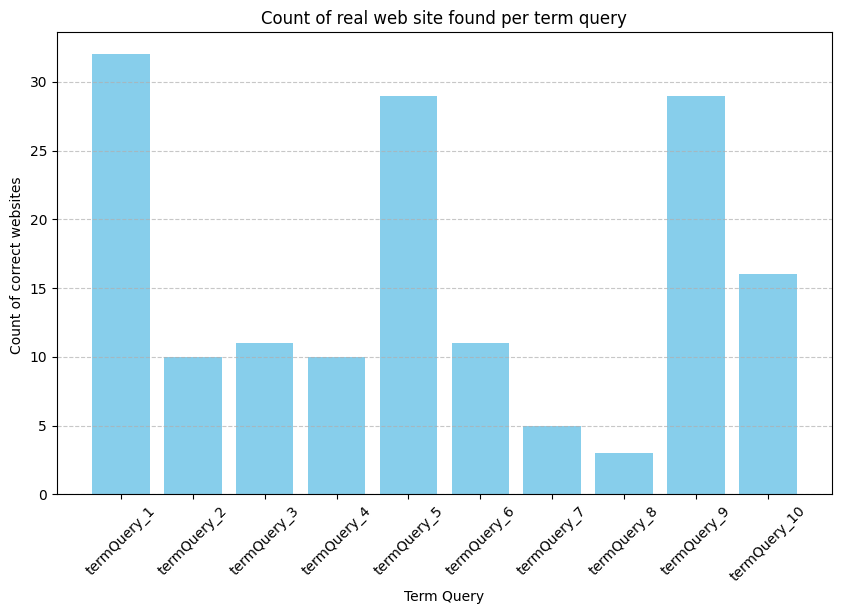

In [48]:

# df_conteo = df_conteo.sort_values(by="Recuento True", ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(df_conteo["termQuery"], df_conteo["Recuento True"], color="skyblue")
plt.xlabel("Term Query")
plt.ylabel("Count of correct websites ")
plt.title("Count of real web site found per term query")
plt.xticks(rotation=45) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [177]:
new_dic_results["termQuery_10"]["matching"].sum()

np.int64(165)

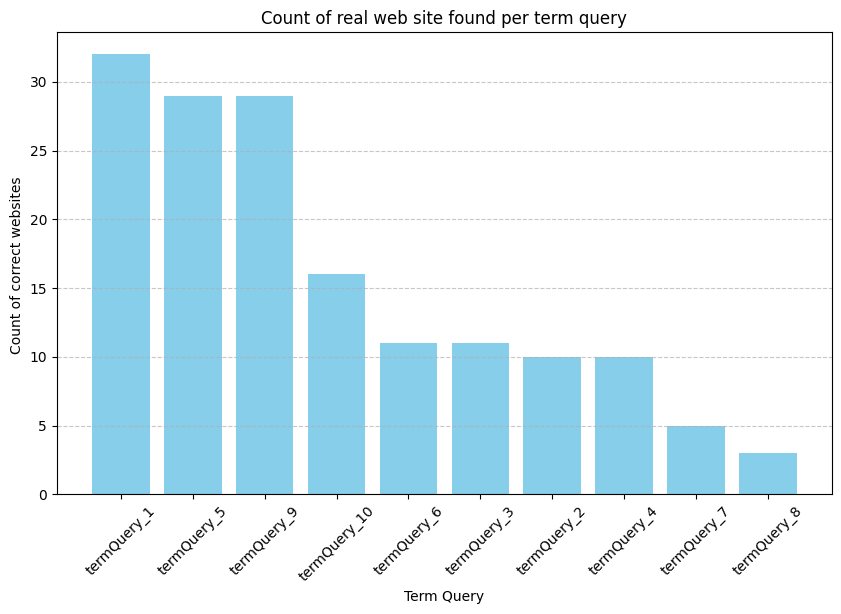

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

conteo_true = {}

for term_query, df in new_dic_results.items():
    empresas_vistas = set()  
    
    for index, row in df.iterrows():
        empresa = row["company_name"]  
        
        if empresa not in empresas_vistas and row["matching"]:
            empresas_vistas.add(empresa) 
            conteo_true[term_query] = conteo_true.get(term_query, 0) + 1  

df_conteo = pd.DataFrame(list(conteo_true.items()), columns=["termQuery", "Recuento True"])

df_conteo = df_conteo.sort_values(by="Recuento True", ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(df_conteo["termQuery"], df_conteo["Recuento True"], color="skyblue")
plt.xlabel("Term Query")
plt.ylabel("Count of correct websites ")
plt.title("Count of real web site found per term query")
plt.xticks(rotation=45) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [29]:
import json

with open("first_approach_4.json", "w") as file:
    json.dump([dic_count_companies, dic_count_queries], file)

In [39]:
import pickle

with open("dataframes.pkl", "wb") as f:
    pickle.dump(new_dic_results, f)


In [152]:
with open("dataframes.pkl", "rb") as f:
    diccionario_df_cargado = pickle.load(f)


# Metrics

## Before searcher

In [154]:
# Number of companies in data with links

print("Number of companies in dataset:", df_sabi.shape[0])
print("Number of companies with links in dataset:", sum(df_sabi["Web site"].notnull()))

Number of companies in dataset: 101
Number of companies with links in dataset: 92


## After searcher

In [155]:
# Number of results per company

results.groupby("company_name").size()/10*100

company_name
Acciona construccion                    100.0
Aena                                    100.0
Air europa lineas aereas                100.0
Airbus defence and space                100.0
Alcampo                                 100.0
                                        ...  
Vodafone españa                         100.0
Volkswagen group españa distribucion    100.0
Volkswagen navarra                      100.0
Vueling airlines                        100.0
Zara españa                             100.0
Length: 96, dtype: float64

In [156]:
# Is the correct URL in the search results? (considering the URL in sabi the ground truth)

pd.merge(df_sabi, results, how = "inner", left_on="Web site", right_on = "display_link")[["Company Name", "Web site", "order","title", "link"]]

,Company Name,Web site,order,title,link
0,Repsol petroleo,www.repsol.com,0,Química de Repsol - Ayudamos a mejorar tu día ...,https://www.repsol.com/es/productos-y-servicio...
1,Repsol petroleo,www.repsol.com,2,Productos y Servicios de Repsol | Repsol,https://www.repsol.com/es/productos-y-servicio...
2,Repsol petroleo,www.repsol.com,4,Principios y certificaciones de los materiales,https://www.repsol.com/es/productos-y-servicio...
3,Repsol petroleo,www.repsol.com,6,Química Repsol: consultas y contacto | Repsol,https://www.repsol.com/es/productos-y-servicio...
4,Repsol petroleo,www.repsol.com,0,Contacto de Productos y Servicios de Repsol | ...,https://www.repsol.com/es/productos-y-servicio...
...,...,...,...,...,...
254,Curenergia comercializador de ultimo recurso,www.iberdrola.com,1,Iberdrola Group offices - Iberdrola,https://www.iberdrola.com/contact/group-offices
255,Curenergia comercializador de ultimo recurso,www.iberdrola.com,5,Iberdrola Group offices - Iberdrola,https://www.iberdrola.com/contact/group-offices
256,Curenergia comercializador de ultimo recurso,www.iberdrola.com,2,Iberdrola Group offices - Iberdrola,https://www.iberdrola.com/contact/group-offices
257,Curenergia comercializador de ultimo recurso,www.iberdrola.com,4,Becas Máster Iberdrola España 2024 - Iberdrola,https://www.iberdrola.com/trabaja-con-nosotros...


In [28]:
df_sabi[df_sabi["Company Name"]== "Club de Futbol Rayo Majadahonda Sociedad Anonima Deportiva"]["Web site"]

5    www.rayomajadahonda.es
Name: Web site, dtype: object

In [ ]:
www.rayomajadahonda.com